In [ ]:
pip install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


tu musisz w dwóch miejscach poniżej wprowadzic nazwe pliku - u góry i na samym dole

# CZĘŚĆ CIĘCIA GŁÓWNEGO PLIKU - PIERWSZE ODPALENIE

TWORZY 5 plików z każdego EVENTU (uderzenia)

tu musisz w dwóch miejscach poniżej wprowadzic nazwe pliku - u góry i na samym dole

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Constants for the script
G_TO_MPS2 = 9.80665  # Conversion factor from g to m/s²
MILLI_G_TO_MPS2 = G_TO_MPS2 / 1000  # Conversion factor from milli-g to m/s²
FORCE_THRESHOLD = 300  # Force threshold for peak detection
WINDOW_SIZE = 0.4  # Window size for event visualization (200 ms before and after the peak)

# Load and prepare the data
data = pd.read_excel('Sławenta_R right hand pad.xlsx')  # Replace with the name of your Excel file
data[['1x', '1y', '1z']] *= MILLI_G_TO_MPS2
data['resultant_acceleration'] = np.sqrt(data['1x']**2 + data['1y']**2 + data['1z']**2)
data['resultant_force'] = np.sqrt(data['fx']**2 + data['fy']**2 + data['fz']**2)

def find_absolute_top_peaks(data, min_time_separation=0.5, force_threshold=FORCE_THRESHOLD, num_peaks=5):
    valid_data = data[data['resultant_force'] >= force_threshold]

    # Next, sort the remaining data points by force value in descending order.
    sorted_data = valid_data.sort_values(by='resultant_force', ascending=False)

    # Now, we'll go through the sorted list and pick out the top peaks, ensuring they are not too close in time.
    top_peaks = []
    for index, row in sorted_data.iterrows():
        if len(top_peaks) >= num_peaks:
            break  # Stop when we have enough peaks

        # Check the time difference with already selected peaks
        time_diffs = [abs(row['Time'] - data['Time'].iloc[prev_index]) for prev_index in top_peaks]
        if all(diff >= min_time_separation for diff in time_diffs):
            top_peaks.append(index)  # This peak is valid; it's not too close to any previously selected peak

    return top_peaks

def visualize_peaks_and_windows(data, top_peak_indices):
    # Generate a plot for visual confirmation with the absolute top peaks and event windows
    plt.figure(figsize=(15, 6))

    # Plot the resultant force
    plt.plot(data['Time'], data['resultant_force'], label='Resultant Force')

    # Highlight the absolute top peaks and their windows on the graph
    for idx, peak_idx in enumerate(top_peak_indices, 1):
        peak_time = data['Time'].iloc[peak_idx]
        start_window = peak_time - WINDOW_SIZE / 2  # Calculate the start of the event window
        end_window = peak_time + WINDOW_SIZE / 2  # Calculate the end of the event window

        # Mark the peak with a larger, more visible marker
        plt.plot(peak_time, data['resultant_force'].iloc[peak_idx], 'X', markersize=12, label=f'Peak {idx}')

        # Highlight the event window
        plt.axvspan(start_window, end_window, color='red', alpha=0.2)

    # Adding details and legend
    plt.xlabel('Time (s)')
    plt.ylabel('Resultant Force (unit)')
    plt.title('Absolute Top Force Peaks with Event Windows')
    plt.legend()
    plt.grid(True)

    # Show the graph
    plt.show()

def generate_summary_table(data, top_peak_indices):
    # Prepare a list to hold the summary data for each event
    summary = []

    for i, peak_idx in enumerate(top_peak_indices):
        # Get the data for this peak event
        event_data = data.iloc[peak_idx]

        # Extract the necessary information
        time_of_max_force = event_data['Time']
        peak_force_value = event_data['resultant_force']
        resultant_acceleration = event_data['resultant_acceleration']

        # Append this data to the summary list
        summary.append({
            'Event': i + 1,
            'Time of Maximum Force (s)': time_of_max_force,
            'Peak Force Value (unit)': peak_force_value,
            'Resultant Acceleration (m/s^2)': resultant_acceleration
        })

    # Convert the summary into a DataFrame
    summary_table = pd.DataFrame(summary)

    return summary_table

def extract_and_save_events(data, top_peaks, original_file_name, window_size=WINDOW_SIZE):
    # Extract and save the events surrounding the top peaks.
    for i, peak_index in enumerate(top_peaks):
        # Calculate the time window for the event.
        peak_time = data['Time'].iloc[peak_index]
        start_time = peak_time - window_size / 2  # e.g., 100ms before the peak
        end_time = peak_time + window_size / 2    # e.g., 100ms after the peak

        # Extract the event data.
        event_data = data[(data['Time'] >= start_time) & (data['Time'] <= end_time)]

        # Save the event data to an Excel file.
        base_name = original_file_name.rsplit('.', 1)[0]
        event_file_name = f'{base_name}_event_{i + 1}.xlsx'        
        event_data.to_excel(event_file_name, index=False)
        print(f'Event {i + 1} data saved to {event_file_name}.')

def main():
    top_peak_indices = find_absolute_top_peaks(data)
    visualize_peaks_and_windows(data, top_peak_indices)
    summary_table = generate_summary_table(data, top_peak_indices)
    print(summary_table)

    # Extract and save events
    original_file_name = 'Sławenta_R right hand pad.xlsx'  # Replace with the name of your original Excel file
    extract_and_save_events(data, top_peak_indices, original_file_name)

# Main function call
main()


   Event  Time of Maximum Force (s)  Peak Force Value (unit)  \
0      1                     1.4180              1347.674227   
1      2                     3.6910              1346.061294   
2      3                     9.8375              1255.885887   
3      4                     5.7265              1125.082570   
4      5                     7.8320              1101.594282   

   Resultant Acceleration (m/s^2)  
0                       89.228625  
1                      103.613965  
2                       99.067025  
3                       96.083715  
4                       85.733256  
Event 1 data saved to Sławenta_R right hand pad_event_1.xlsx.
Event 2 data saved to Sławenta_R right hand pad_event_2.xlsx.
Event 3 data saved to Sławenta_R right hand pad_event_3.xlsx.
Event 4 data saved to Sławenta_R right hand pad_event_4.xlsx.
Event 5 data saved to Sławenta_R right hand pad_event_5.xlsx.


# a tu musisz zmienic juz na konkretny event z tych zapisanych plikow co widzisz powyzej na koncu kodu - czyli tu w nazwie pliku musi byc event_1 do event_5. Inaczej się nie obliczy prędkości bo psuje wykres. musi byc analiza pojedynczego uderzenia. jak tu wpiszesz nazwe pliku to albo po kolei bloki odpalasz albo znowu run notebook

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the uploaded Excel file

data1 = pd.read_excel('Krawczyk_G right hand pad_event_2.xlsx')

data1

Time        1x        1y         1z         2x        2y        2z  \
0    12.410  1.431820 -5.660241   0.713515 -991.51600  -478.057  -88.8726   
1    12.411  1.386327 -5.679394   0.809290 -983.45800  -490.508  -93.2674   
2    12.412  1.324074 -5.717699   0.895486 -969.78600  -512.482  -80.5713   
3    12.413  1.369567 -5.856571   0.952950 -965.63500  -518.830  -72.7583   
4    12.414  1.522806 -6.096010   0.981685 -971.00700  -509.553  -69.8285   
..      ...       ...       ...        ...        ...       ...       ...   
395  12.805 -5.856571  3.665745  13.075501  163.82800  2277.240  611.1210   
396  12.806 -5.176577  3.526873  12.907905   77.39730  2294.330  589.1470   
397  12.807 -4.568418  3.275470  13.097075   25.39220  2305.560  574.0100   
398  12.808 -4.032083  2.911526  13.643011    7.81298  2310.930  565.7080   
399  12.809 -3.553214  2.755894  13.863269  -37.35580  2309.220  560.3370   

           3x        3y        3z        fx        fy       fz  \
0    -424.831 -590.1240 -399.6830 -0.360870 -0.546089 -2.12384   
1    -436.306 -593.0540 -411.6460 -0.360870 -0.546089 -1.41589   
2    -433.864 -583.7760 -447.7810 -0.541306  0.000000 -2.12384   
3    -441.189 -594.7630 -450.7110 -0.360870 -0.364059 -3.53973   
4    -458.280 -626.0150 -420.4360 -0.541306 -0.546089 -2.83179   
..        ...       ...       ...       ...       ...      ...   
395 -1272.290  116.2180 -105.7190 -2.165220 -0.182030  0.00000   
396 -1277.670  102.5450 -129.6470 -1.082610  0.364059 -2.83179   
397 -1277.670   85.9427 -120.6130 -0.721741  0.182030 -2.12384   
398 -1272.290   66.4103  -78.6181 -0.360870 -0.182030 -2.83179   
399 -1270.830   46.6337  -68.1194  0.000000 -0.546089 -2.83179   

     resultant_acceleration  resultant_force  
0                  5.881968         2.222417  
1                  5.901895         1.559867  
2                  5.936931         2.191736  
3                  6.089602         3.576654  
4                  6.359558         2.934324  
..                      ...              ...  
395               14.788706         2.172858  
396               14.347467         3.053460  
397               14.252457         2.250498  
398               14.521241         2.860489  
399               14.574310         2.883964  

[400 rows x 15 columns]

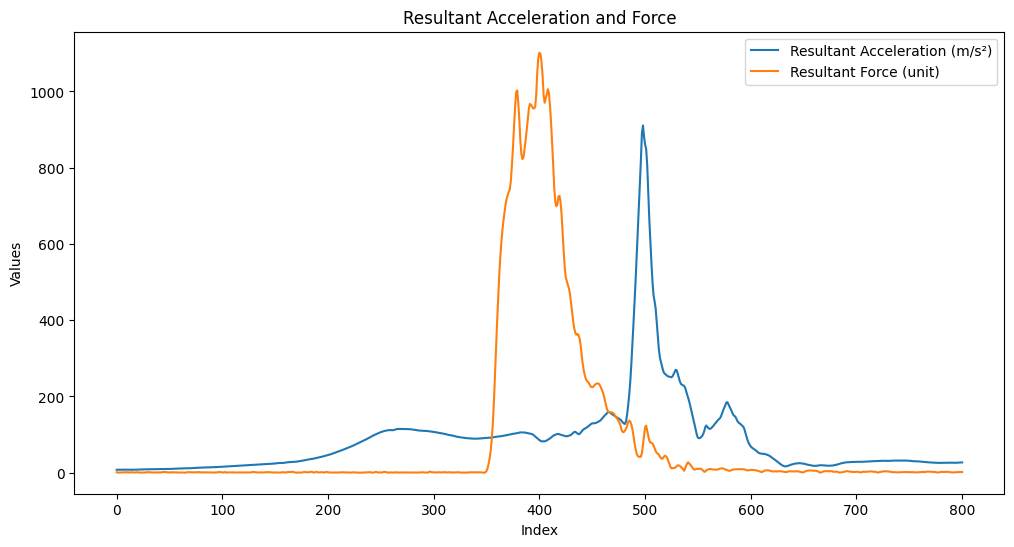

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the uploaded Excel file


# Check if 'resultant_acceleration' and 'resultant_force' columns are present in the data
if 'resultant_acceleration' in data1.columns and 'resultant_force' in data1.columns:
    # Plotting 'resultant_acceleration' and 'resultant_force' on the same graph
    plt.figure(figsize=(12, 6))

    # Plot 'resultant_acceleration'
    plt.plot(data1['resultant_acceleration'], label='Resultant Acceleration (m/s²)')

    # Plot 'resultant_force'
    plt.plot(data1['resultant_force'], label='Resultant Force (unit)')

    # Adding plot details
    plt.title('Resultant Acceleration and Force')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()

    plt.show()
else:
    print("The columns 'resultant_acceleration' and/or 'resultant_force' were not found in the data.")


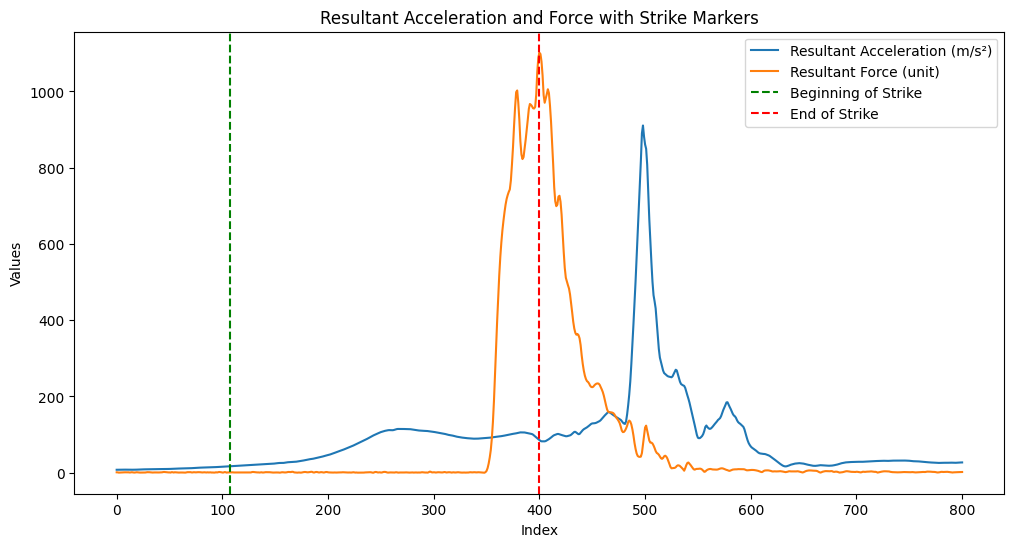

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Define the threshold for the beginning of the strike
acceleration_threshold = 17  # m/s²

# Find the index where resultant_acceleration first exceeds the threshold
strike_begin_index = next((index for index, value in enumerate(data1['resultant_acceleration']) if value > acceleration_threshold), None)

# Find the index of the highest force value (end of the strike)
max_force_index = data1['resultant_force'].idxmax()

# Plotting the resultant acceleration, resultant force, and marking the beginning and end of the strike
plt.figure(figsize=(12, 6))

# Plot 'resultant_acceleration'
plt.plot(data1['resultant_acceleration'], label='Resultant Acceleration (m/s²)')

# Plot 'resultant_force'
plt.plot(data1['resultant_force'], label='Resultant Force (unit)')

# Mark the beginning of the strike
if strike_begin_index is not None:
    plt.axvline(x=strike_begin_index, color='green', linestyle='--', label='Beginning of Strike')

# Mark the end of the strike
if max_force_index is not None:
    plt.axvline(x=max_force_index, color='red', linestyle='--', label='End of Strike')

# Adding plot details
plt.title('Resultant Acceleration and Force with Strike Markers')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

plt.show()


In [ ]:
import pandas as pd

# Load the data


# Define the threshold for the beginning of the strike
acceleration_threshold = 12  # m/s²

# Find the index where resultant_acceleration first exceeds the threshold
strike_begin_index = next((index for index, value in enumerate(data1['resultant_acceleration']) if value > acceleration_threshold), None)

# Find the index of the highest force value (end of the strike)
max_force_index = data1['resultant_force'].idxmax()

# Calculate strike duration in terms of time
if strike_begin_index is not None and max_force_index is not None:
    strike_duration = data1['Time'].iloc[max_force_index] - data1['Time'].iloc[strike_begin_index]
    # Get the times of beginning and end of the strike, and time of max force
    begin_time = data1['Time'].iloc[strike_begin_index]
    end_time = data1['Time'].iloc[max_force_index]
    time_of_max_force = data1['Time'].iloc[max_force_index]

    # Get the max force value and acceleration value at time of max force
    max_force_value = data1['resultant_force'].iloc[max_force_index]
    acceleration_at_max_force = data1['resultant_acceleration'].iloc[max_force_index]

    # Create a summary table
    summary_data = {
        'Time of Beginning of Strike': [begin_time],
        'Time of End of Strike': [end_time],
        'Strike Duration (s)': [strike_duration],
        'Time of Max Force (s)': [time_of_max_force],
        'Max Force Value (unit)': [max_force_value],
        'Acceleration at Max Force (m/s²)': [acceleration_at_max_force]
    }

    summary_table = pd.DataFrame(summary_data)
else:
    summary_table = pd.DataFrame(columns=['Time of Beginning of Strike', 'Time of End of Strike', 'Strike Duration (s)', 'Time of Max Force (s)', 'Max Force Value (unit)', 'Acceleration at Max Force (m/s²)'])

display(summary_table)


Time of Beginning of Strike  Time of End of Strike  Strike Duration (s)  \
0                        7.668                  7.832                0.164   

   Time of Max Force (s)  Max Force Value (unit)  \
0                  7.832             1101.594282   

   Acceleration at Max Force (m/s²)  
0                         85.733256

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



# Function to compute velocity from acceleration
def compute_velocity(acceleration, time_intervals):
    velocity = np.zeros(len(acceleration))
    for i in range(1, len(velocity)):
        velocity[i] = velocity[i - 1] + acceleration[i - 1] * time_intervals[i - 1]
    return velocity

# Time intervals (assumes consistent sampling rate)
time_intervals = np.diff(data1['Time'])

# Compute velocities for 2x, 2y, 2z components
velocity_1x = compute_velocity(data1['1x'].iloc[:-1].values, time_intervals)
velocity_1y = compute_velocity(data1['1y'].iloc[:-1].values, time_intervals)
velocity_1z = compute_velocity(data1['1z'].iloc[:-1].values, time_intervals)

# Pad velocities with initial value (0) to match the length of the DataFrame
data1['velocity_1x'] = np.append([0], velocity_1x)
data1['velocity_1y'] = np.append([0], velocity_1y)
data1['velocity_1z'] = np.append([0], velocity_1z)

# Compute resultant velocity
data1['resultant_velocity'] = np.sqrt(data1['velocity_1x']**2 + data1['velocity_1y']**2 + data1['velocity_1z']**2)

# Plotting the resultant velocity
plt.figure(figsize=(12, 6))


# Plot 'resultant_velocity'
plt.plot(data1['Time'], data1['resultant_velocity'], label='Resultant Velocity (m/s)', color='purple')

# Adding plot details
plt.title('Resultant Velocity Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Resultant Velocity (m/s)')
plt.legend()

plt.show()


In [ ]:
# Plotting the specific velocity
plt.figure(figsize=(12, 6))


# Plot 'resultant_velocity'
plt.plot(data1['Time'], data1['velocity_1x'], label='X Velocity (m/s)', color='red')

# Adding plot details
plt.title('X Velocity Over Time')
plt.xlabel('Time (s)')
plt.ylabel('X Velocity (m/s)')
plt.legend()

plt.show()

In [ ]:
# Plotting the specific velocity
plt.figure(figsize=(12, 6))


# Plot 'resultant_velocity'
plt.plot(data1['Time'], data1['velocity_1y'], label='Y Velocity (m/s)', color='blue')

# Adding plot details
plt.title('Y Velocity Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Y Velocity (m/s)')
plt.legend()

plt.show()

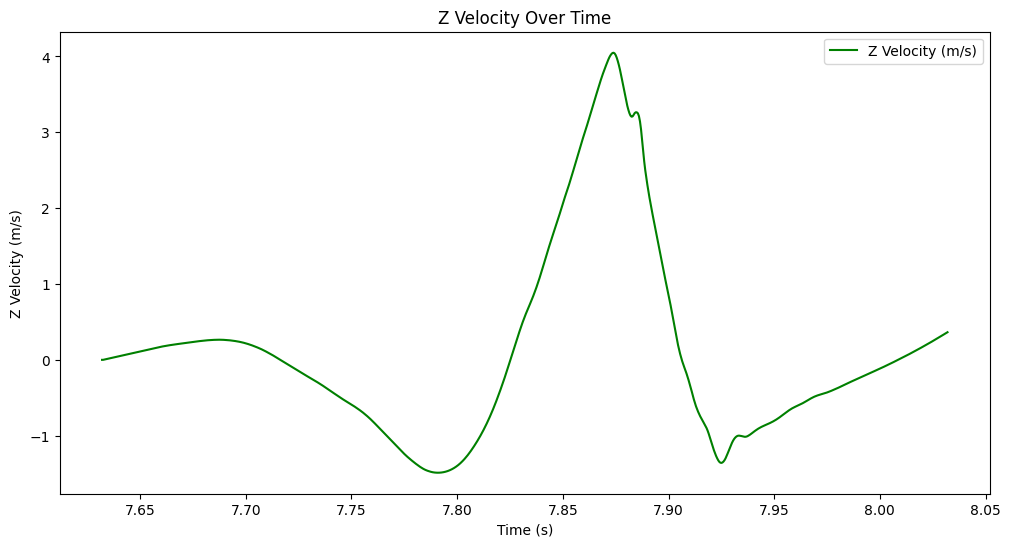

In [ ]:
# Plotting the specific velocity
plt.figure(figsize=(12, 6))


# Plot 'resultant_velocity'
plt.plot(data1['Time'], data1['velocity_1z'], label='Z Velocity (m/s)', color='green')

# Adding plot details
plt.title('Z Velocity Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Z Velocity (m/s)')
plt.legend()

plt.show()

In [ ]:
# Determining the time of the maximum velocity value

# Find the index of the highest velocity value
max_velocity_index = data1['resultant_velocity'].idxmax()

# Get the time of the maximum velocity value
time_of_max_velocity = data1['Time'].iloc[max_velocity_index]

# Display the time
print("Time of Maximum Velocity:", time_of_max_velocity)

Time of Maximum Velocity: 7.874


In [ ]:
# Updating the summary table to include the value of velocity at the time of maximum force value

# Get the value of velocity at the time of maximum force
velocity_at_max_force = data1['resultant_velocity'].iloc[max_force_index]

# Update the summary table
if not summary_table.empty:
    summary_table['Velocity at Max Force (m/s)'] = [velocity_at_max_force]
else:
    # If the summary table is empty, create a new one with this data
    summary_table = pd.DataFrame({'Velocity at Max Force (m/s)': [velocity_at_max_force]})

# Display the updated summary table
display(summary_table)


Time of Beginning of Strike  Time of End of Strike  Strike Duration (s)  \
0                        7.668                  7.832                0.164   

   Time of Max Force (s)  Max Force Value (unit)  \
0                  7.832             1101.594282   

   Acceleration at Max Force (m/s²)  Velocity at Max Force (m/s)  
0                         85.733256                    10.008814

In [ ]:
# Updating the summary table to include the value of velocity at the time of maximum force value

# Get the value of velocity at the time of maximum force
velocity_at_max_force = data1['resultant_velocity'].iloc[max_force_index]

# Update the summary table
if not summary_table.empty:
    summary_table['Velocity at Max Force (m/s)'] = [velocity_at_max_force]
else:
    # If the summary table is empty, create a new one with this data
    summary_table = pd.DataFrame({'Velocity at Max Force (m/s)': [velocity_at_max_force]})

# Display the updated summary table
display(summary_table)


Time of Beginning of Strike  Time of End of Strike  Strike Duration (s)  \
0                        7.668                  7.832                0.164   

   Time of Max Force (s)  Max Force Value (unit)  \
0                  7.832             1101.594282   

   Acceleration at Max Force (m/s²)  Velocity at Max Force (m/s)  
0                         85.733256                    10.008814

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=df041f88-6920-47c1-80f6-2b62e7875599' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>